## What is the goal of this project?

#### The school world contains so much data and yet barely any schools are taking advantage of it.
#### Their administrators don't have the time to dig deep into the data and pull out information
#### This project will act almost as a POC to a potential plugin/dashboard that schools can enter into their Student Information Systems where administrators can quickly yield results that will help guide them to action

#### Some questions that we will be exploring: Can we predict the ELA (English Language Acquisition) status/level of a student based on their grade? What about their current english grade based on the previous 2 years of English test grades? Taking a mixed effect model and looking at differences. 
#### There are many more questions we can ask of the data, but for our current scope, we will focus on these 3.

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import scipy.stats as stats
import pylab 
import math
%matplotlib inline

In [2]:
# Loading the data in long format (each respondent has one row per response)
data=pd.read_csv('Report.csv')
#elaDummies = pd.get_dummies(data["ca_elastatus"])
#data = data.append(elaDummies)
print(data.shape)
print(data.columns)

(1478, 18)
Index(['student_number', 'grade_level', 'ca_elastatus', 'Race', 'Zip', 'E1',
       'E2', 'E3', 'M1', 'M2', 'M3', 'Days Attended', 'Days Absent 2018-2019',
       'Days Enrolled 2018-2019', 'Attendance Rate 2018-2019',
       'Absent Rate 2018-2019', 'Current English Grade', 'Current Math Grade'],
      dtype='object')


### Data cleanup and converting non-numerical fields to numeric

In [3]:
#I'm not exactly happy with this as we're essentially giving students 0 for missing data, but we have to start somewhere
#I might run another dataset dropping them and looking at the difference.
data= data.fillna(0)

In [4]:
#This is going to take our grades that are in letters and convert them to numbers
#We're not going to worry too much about the + and - even though they have a slight difference, we will group them
def conditions(x):
    if (x == 'A' or x == 'A-'):
        return 1
    elif (x == 'B' or x == 'B+' or x == 'B-'):
        return 2
    elif (x == 'C' or x == 'C+' or x == 'C-'):
        return 3
    elif (x == 'D' or x == 'D-' or x == 'D+'):
        return 4
    elif (x == 'F'):
        return 5
    else:
        return 0

func = np.vectorize(conditions)
#do it for english grades
EngGradeDummies = func(data["Current English Grade"])
data["CurEngGrade"] = EngGradeDummies

#math
MathGradeDummies = func(data["Current Math Grade"])
data["CurMathGrade"] = MathGradeDummies

In [5]:
#this function will take our ELA status and convert them to numbers
def conditionsEla(x):
    if x == 'EO':
        return 1
    elif x == 'EL':
        return 2
    elif x == 'IFEP':
        return 3
    elif x == 'RFEP':
        return 4
    

func = np.vectorize(conditionsEla)
elaDummies = func(data["ca_elastatus"])
data["elastatus"] = elaDummies

In [6]:
#OHE for race
#race = pd.get_dummies(data["Race"], )
#data = data.append(race)
#data = data.fillna(0)


In [7]:
data.columns

Index(['student_number', 'grade_level', 'ca_elastatus', 'Race', 'Zip', 'E1',
       'E2', 'E3', 'M1', 'M2', 'M3', 'Days Attended', 'Days Absent 2018-2019',
       'Days Enrolled 2018-2019', 'Attendance Rate 2018-2019',
       'Absent Rate 2018-2019', 'Current English Grade', 'Current Math Grade',
       'CurEngGrade', 'CurMathGrade', 'elastatus'],
      dtype='object')

In [8]:
#"Black or African American", 
    #     "Cambodian", "Chinese", "Filipino", "Hispanic", "Multi", "Other Pac Islander", "White"

In [69]:
data["absentrate"] = data["Days Absent 2018-2019"]
#create our X variable
mainSet = data[["grade_level", "absentrate", "E1", "E2", 'E3'
         , "M1", "M2", "M3", "Zip", "CurEngGrade", "CurMathGrade", "elastatus" ]]

 
#X = mainSet.drop("E1", axis=1)
X = mainSet[["E1","E2", "E3", "absentrate", "elastatus", "CurEngGrade"]]

#squared
X["E2_Sq"] = mainSet["E2"] ** 2
X["E3_Sq"] = mainSet["E3"] ** 2
X["CurEngGrade_Sq"] = mainSet["CurEngGrade"] ** 2
X["absentrate_Sq"] = mainSet["absentrate"] ** 2
X["elastatus_Sq"] = mainSet["elastatus"] ** 2

#log
def getlog(x):
    if x > 0:
        return math.log(x)
    else:
        return x
X["E2_log"] = X["E2"].apply(getlog)
X["E3_log"] = X["E3"].apply(getlog)
X["CurEngGrade_log"] = X["CurEngGrade"].apply(getlog)
X["absentrate_log"] = X["absentrate"].apply(getlog)
X["elastatus_log"] = X["elastatus"].apply(getlog)

#square root
def squareroot(x):
    if x > 1:
        return math.sqrt(x)
    else:
        return x

X["E2_sqrt"] = X["E2"].apply(squareroot)
X["E3_sqrt"] = X["E3"].apply(squareroot)
X["CurEngGrade_sqrt"] = X["CurEngGrade"].apply(squareroot)
X["absentrate_sqrt"] = X["absentrate"].apply(squareroot)
X["elastatus_sqrt"] = X["elastatus"].apply(squareroot)


X["inDanger"] = np.where(mainSet["CurEngGrade"] >= 4, 1, 0).astype('int')
y = X["E1"]
X = X.drop("E1", axis=1)

#X = (X - X.mean()) / (X.max() - X.min())

#from sklearn.decomposition import PCA


#X_pca = pca.fit_transform(X)

c:\users\sakok\miniconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
c:\users\sakok\miniconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
c:\users\sakok\miniconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [70]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: E1, dtype: object

In [71]:
#clean up the spaces in some areas
y = np.where(y == ' ', 0, y).astype("int")

X["E2"] = np.where(X["E2"] == ' ', 0, X["E2"]).astype("int")

X["E3"] = np.where(X["E3"] == ' ', 0, X["E3"]).astype("int")

#X["M1"] = np.where(X["M1"] == ' ', 0, X["M1"]).astype("int")

#X["M2"] = np.where(X["M2"] == ' ', 0, X["M2"]).astype("int")

#X["M3"] = np.where(X["M3"] == ' ', 0, X["M3"]).astype("int")

c:\users\sakok\miniconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [73]:
#split the data for analysis
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35)

In [52]:
X.head()

,E2,E3,absentrate,elastatus,CurEngGrade,E2_Sq,E3_Sq,CurEngGrade_Sq,absentrate_Sq,elastatus_Sq,...,E3_log,CurEngGrade_log,absentrate_log,elastatus_log,E2_sqrt,E3_sqrt,CurEngGrade_sqrt,absentrate_sqrt,elastatus_sqrt,inDanger
0,0,0,0,1,0,0,0,0,0,1,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000,0
1,0,0,1,2,0,0,0,0,1,4,...,0.0,0.0,0.000000,0.693147,0.0,0.0,0.0,1.000000,1.414214,0
2,0,0,2,1,0,0,0,0,4,1,...,0.0,0.0,0.693147,0.000000,0.0,0.0,0.0,1.414214,1.000000,0
3,0,0,11,2,0,0,0,0,121,4,...,0.0,0.0,2.397895,0.693147,0.0,0.0,0.0,3.316625,1.414214,0
4,0,0,5,1,0,0,0,0,25,1,...,0.0,0.0,1.609438,0.000000,0.0,0.0,0.0,2.236068,1.000000,0


In [53]:
pca = TruncatedSVD(2).fit_transform(X_train, y_train)

### Explore the data 

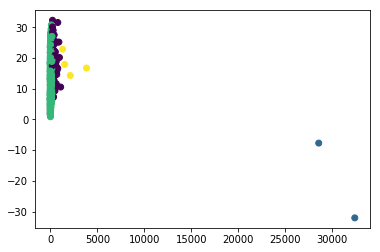

Comparing k-means clusters against the data:
col_0    0    1    2    3    4
row_0                         
0       28   39   20   13    6
1        1    0    0    0    1
2      334  274  173  169  120
3        2    1    1    0    0


In [54]:
#I like the 3 clusters
y_pred = KMeans(n_clusters=4).fit_predict(pca)

# Plot the solution.
plt.scatter(pca[:, 0], pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y_train))

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.996397666125953
For n_clusters = 3 The average silhouette_score is : 0.9483096758939861
For n_clusters = 4 The average silhouette_score is : 0.8280479672716311
For n_clusters = 5 The average silhouette_score is : 0.821126545952769
For n_clusters = 6 The average silhouette_score is : 0.7792695429627665


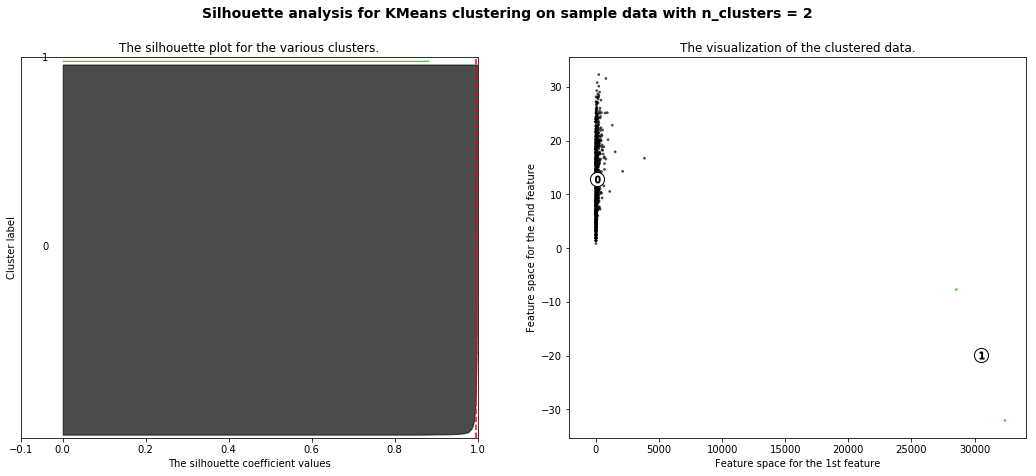

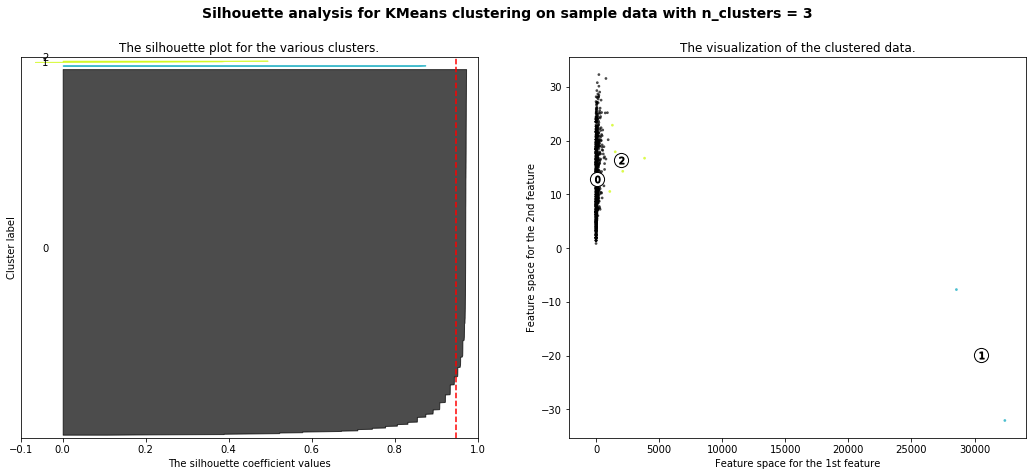

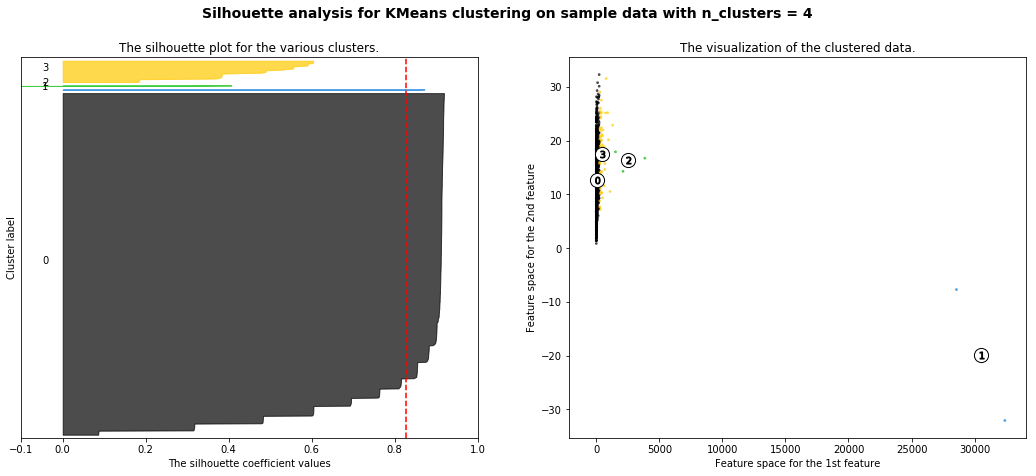

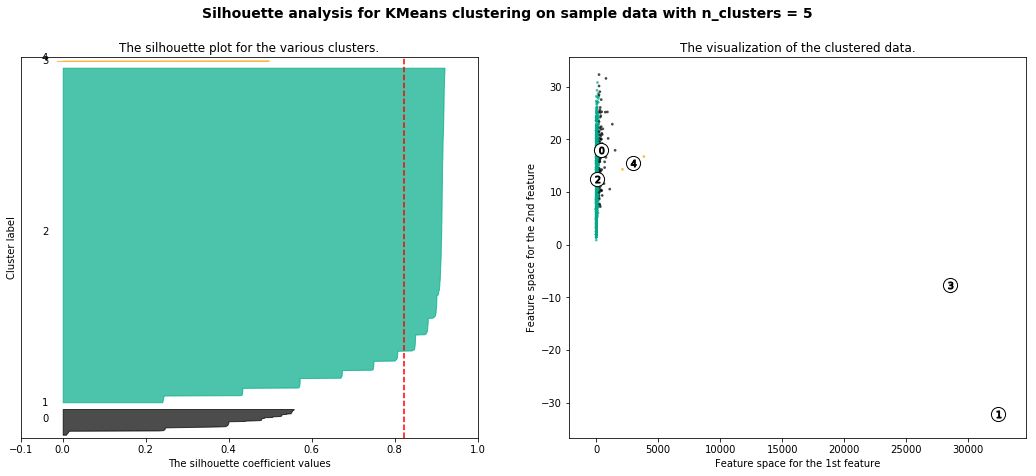

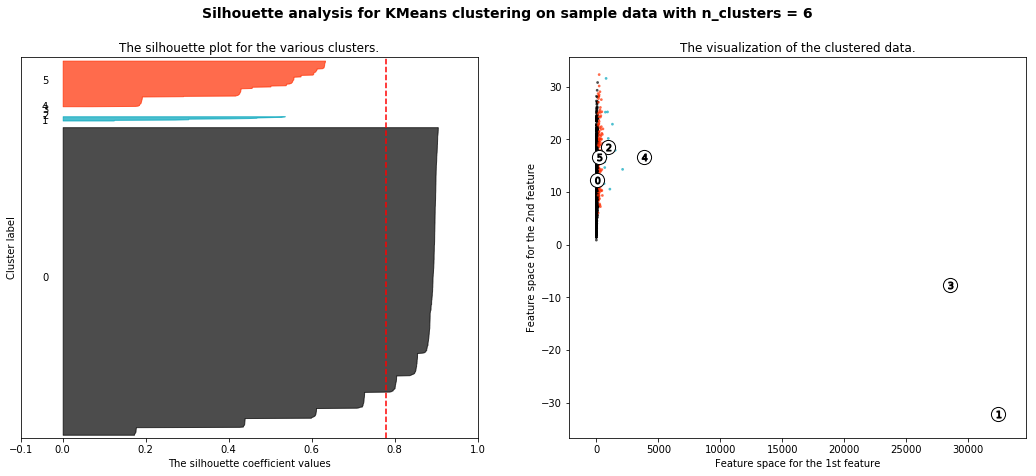

In [68]:
#Let's look at silhouette score

from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X1 = pca

y = y_pred


# For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X1) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X1)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X1, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X1, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

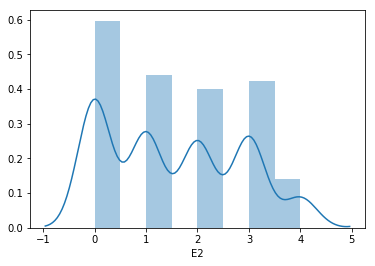

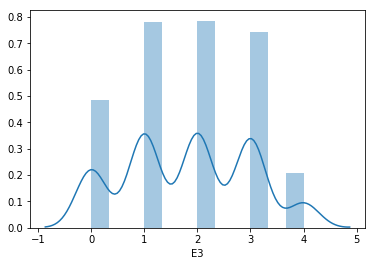

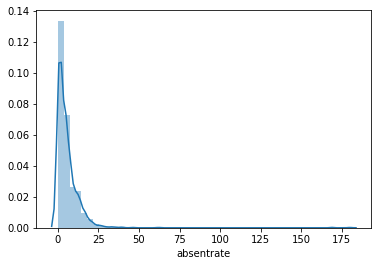

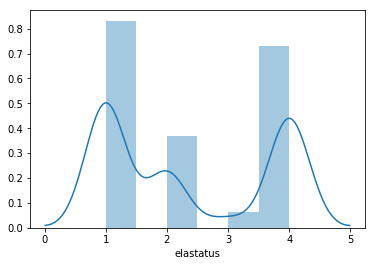

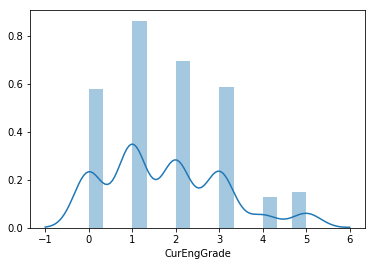

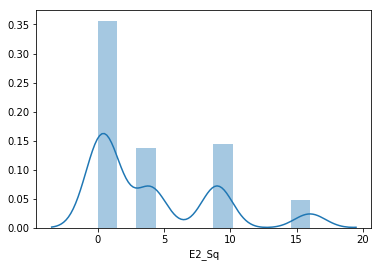

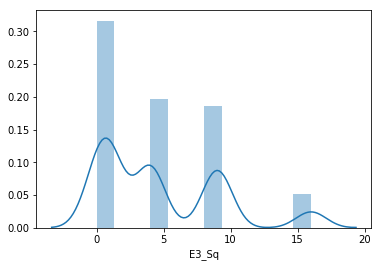

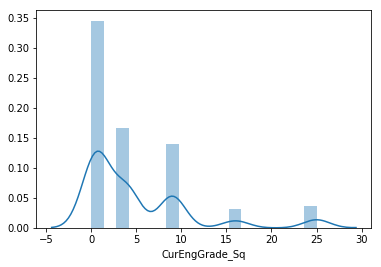

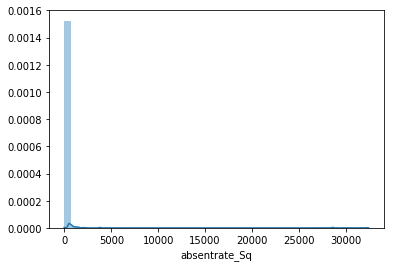

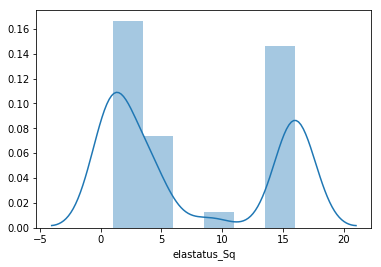

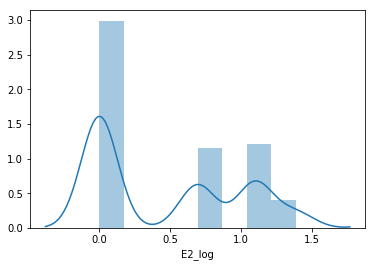

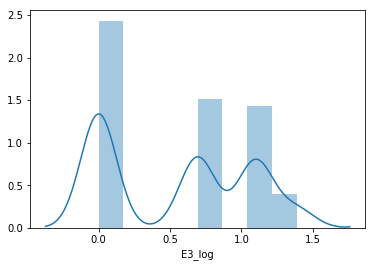

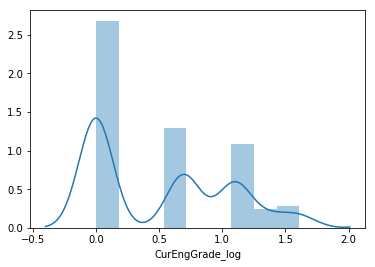

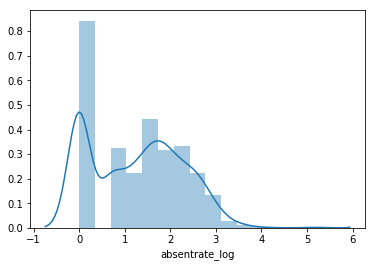

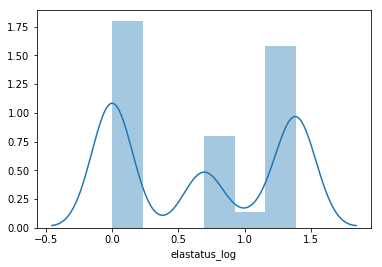

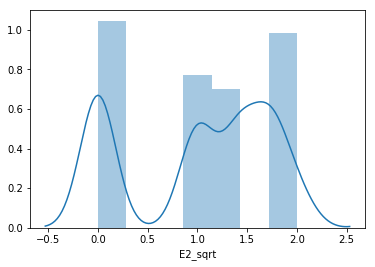

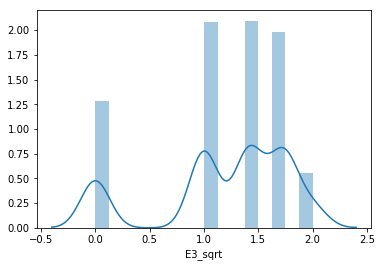

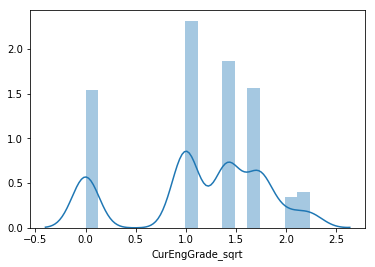

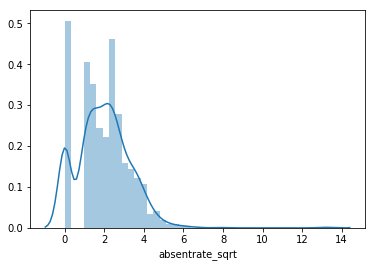

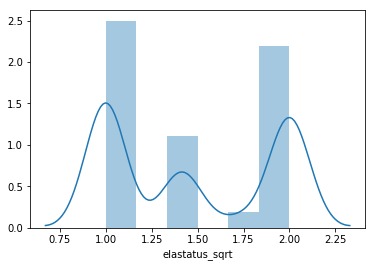

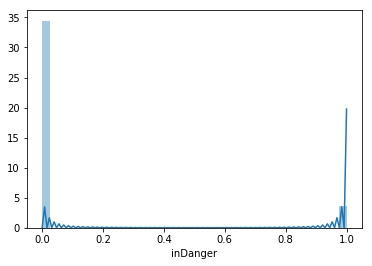

In [55]:
for x1 in X:
    sns.distplot(X[x1])
    plt.show()


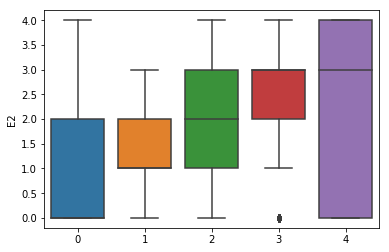

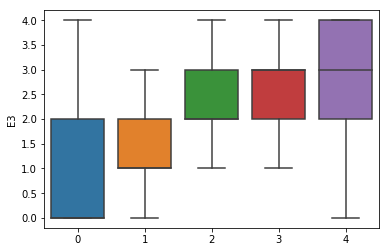

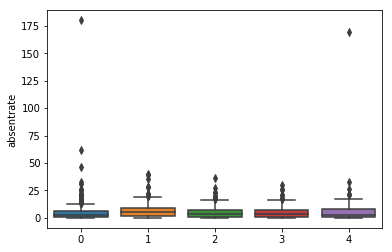

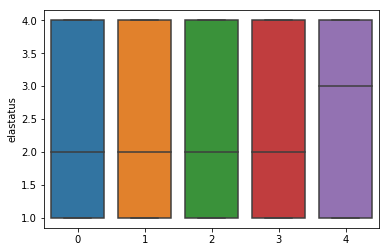

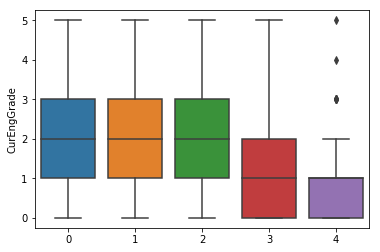

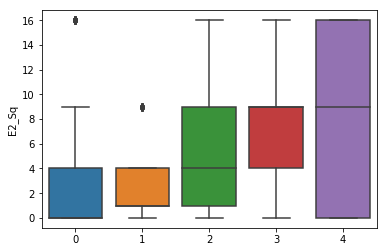

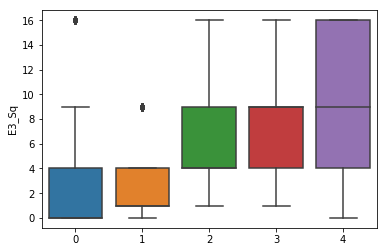

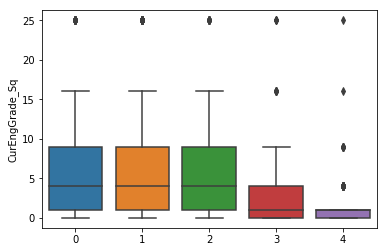

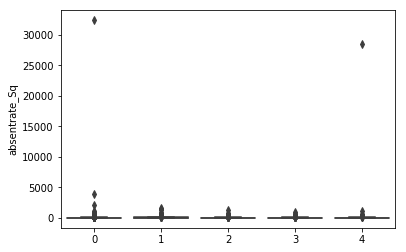

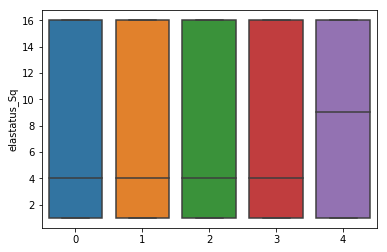

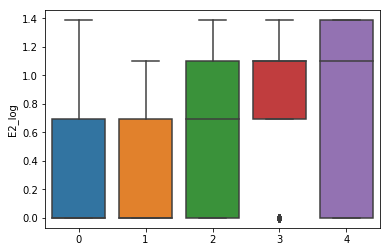

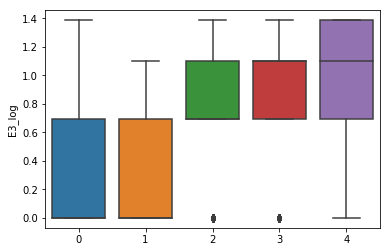

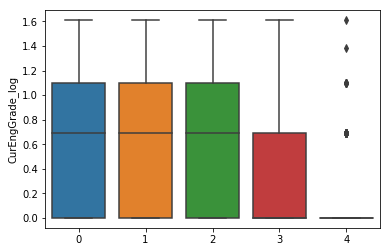

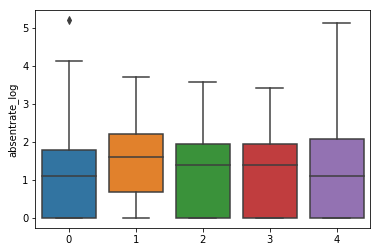

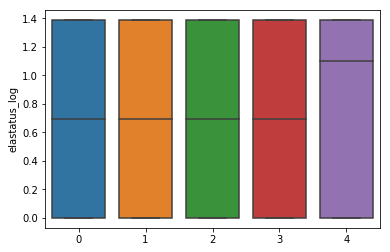

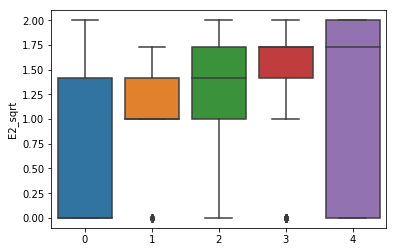

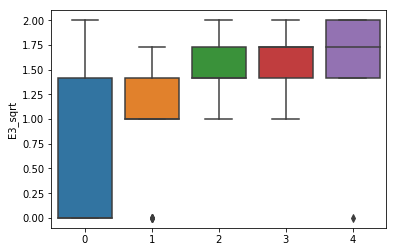

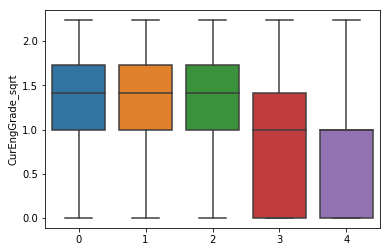

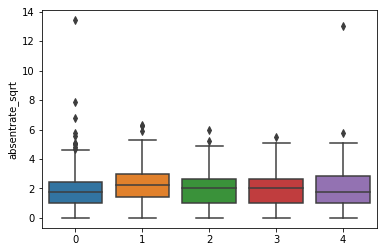

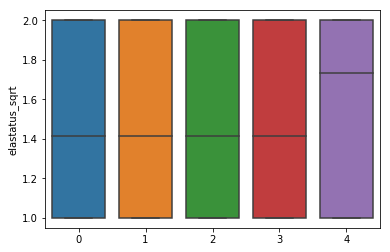

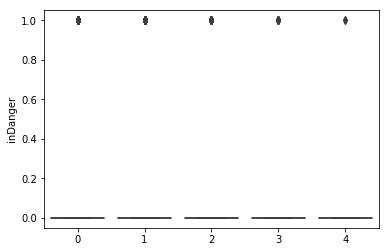

In [56]:
for x1 in X:
    sns.boxplot(x=y,y=X[x1] )
    plt.show()


E2


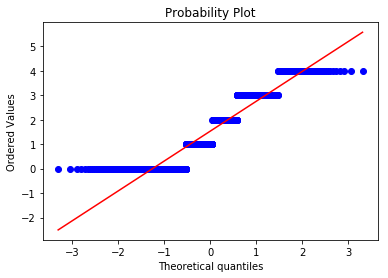

E3


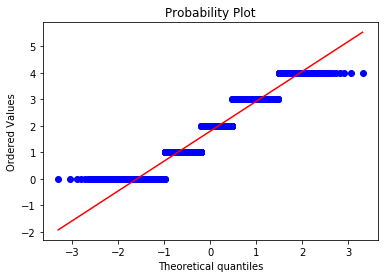

absentrate


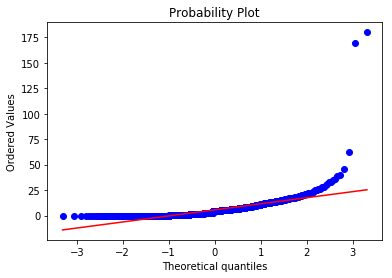

elastatus


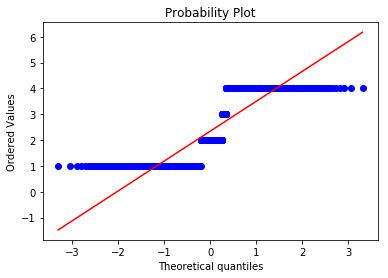

CurEngGrade


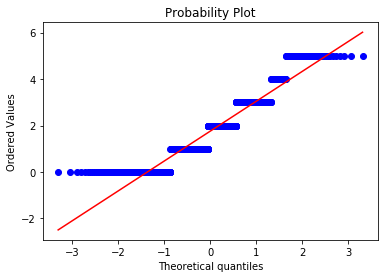

E2_Sq


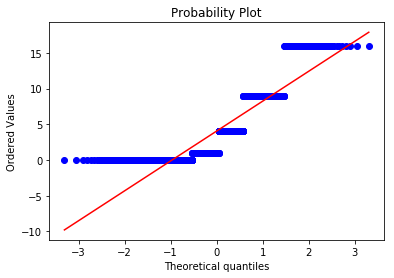

E3_Sq


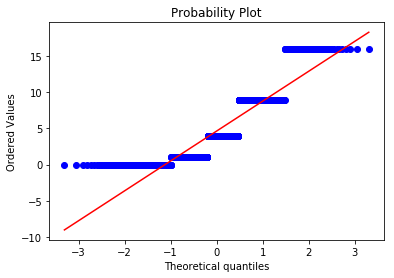

CurEngGrade_Sq


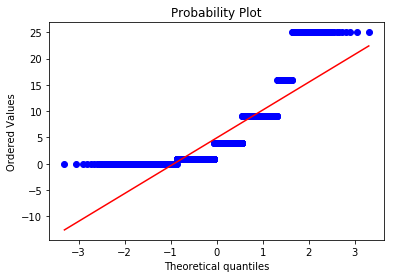

absentrate_Sq


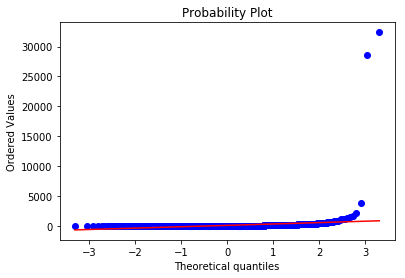

elastatus_Sq


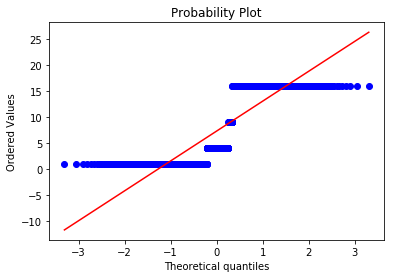

E2_log


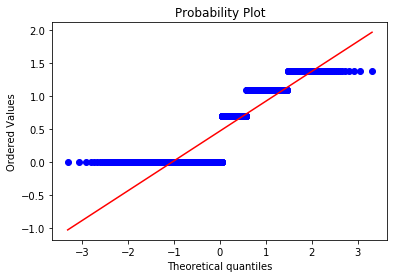

E3_log


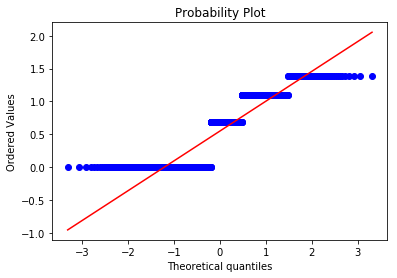

CurEngGrade_log


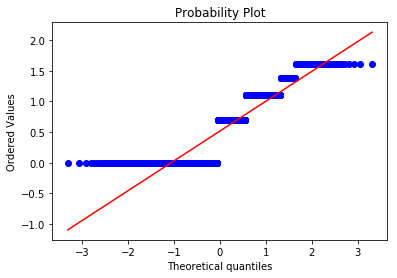

absentrate_log


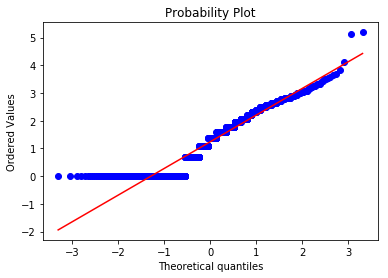

elastatus_log


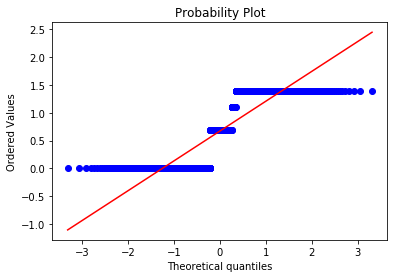

E2_sqrt


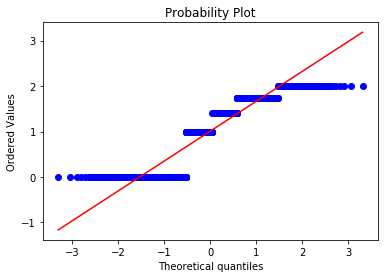

E3_sqrt


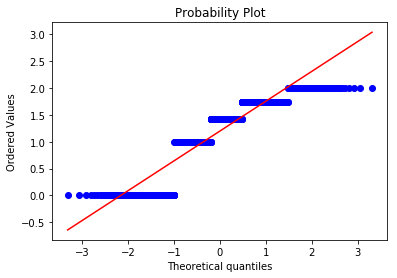

CurEngGrade_sqrt


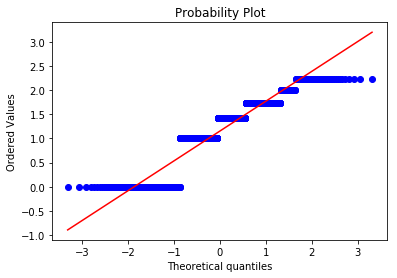

absentrate_sqrt


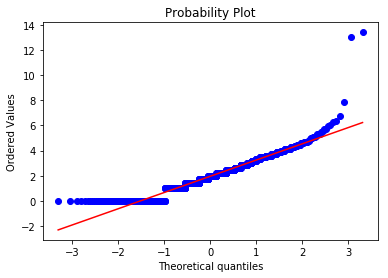

elastatus_sqrt


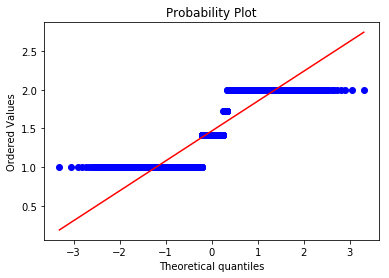

inDanger


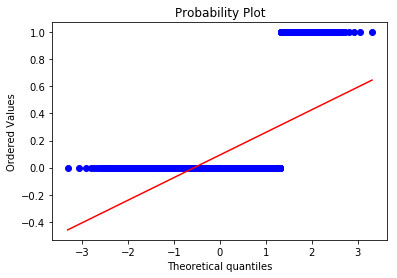

In [66]:
for x1 in X:
    print(x1)
    stats.probplot(X[x1], dist="norm", plot=pylab)
    pylab.show()

### There is a lot of categorical data
#### Some of it is due to converting the grades and ELA status to OHE

In [ ]:
#The interesting one for me is our distribution of ELA status at the bottom. 

## ELA Status of a student based on their English grades

In [ ]:
#will start with a logistic regression as this is a classification problem

In [74]:
# Declare a logistic regression classifier.
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble

#lr = ensemble.GradientBoostingClassifier(subsample=.2, n_estimators=300, max_features=2)
lr = LogisticRegression()
# Fit the model.
lr.fit(X_train, y_train)

# Display.
print('Coefficients')
print(lr.coef_)

#print(lr.intercept_)
pred_y = lr.predict(X_test)

print('\n Accuracy by E1')
print(pd.crosstab(pred_y, y_test))

print('\n Percentage accuracy')
print(lr.score(X_train, y_train))

print("Cross Val Score")
print(cross_val_score(lr,X_test,y_test,cv=10))

c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Defau

Coefficients
[[-5.21264649e-02 -1.33643641e+00  2.13737053e-02  7.70190212e-01
   3.19155061e-01 -4.37884298e-02  4.00824572e-01  1.11851145e-02
   7.09526716e-05 -2.33651333e-01  2.05798795e+00  1.22930794e+00
  -2.95331486e-01 -6.93603040e-02  2.81275997e-01 -1.52719881e+00
  -2.54085246e+00  5.03981156e-01 -2.86070460e-01  9.05564593e-01
  -9.63762108e-01]
 [ 1.46249239e+00  2.40375864e-01  9.35091662e-02 -2.11727344e-01
   9.68111088e-02 -5.99794382e-01 -2.39512560e-01 -8.94536432e-02
  -1.48713858e-03 -4.19468604e-02 -1.93593413e+00 -1.10051923e+00
   2.96126519e-01 -1.61768968e-01  1.47576915e+00  2.66966271e+00
   8.32082875e-01 -1.17407389e-01 -7.37557482e-02 -1.00521523e+00
   1.03839278e+00]
 [ 8.30754121e-01  1.04920104e+00  8.24044206e-02 -1.07210314e+00
  -1.90188656e-01 -3.81860395e-01 -3.73227714e-01  3.56399338e-02
  -2.45562905e-03  2.76787940e-01  1.08587750e+00  7.55922615e-01
  -4.54117853e-02  1.49166265e-01  3.81374627e-01  3.19303797e-01
   8.05181044e-01  8.6423

c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Defau

In [75]:
print(metrics.classification_report(y_test,pred_y))

              precision    recall  f1-score   support

           0       0.66      0.65      0.65       144
           1       0.62      0.76      0.68       136
           2       0.37      0.22      0.28        87
           3       0.44      0.49      0.47        89
           4       0.67      0.63      0.65        62

   micro avg       0.58      0.58      0.58       518
   macro avg       0.55      0.55      0.55       518
weighted avg       0.56      0.58      0.57       518



In [76]:
#next we will look at a random forest
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier(n_estimators=200, max_depth=20 )

rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test)

print(rfc.score(X_train,y_train))
print('\n Accuracy by ela status')
print(pd.crosstab(pred_rfc, y_test))

cross_val_score(rfc,X_test, y_test,cv=10)

0.9041666666666667

 Accuracy by ela status
col_0    0   1   2   3   4
row_0                     
0      104  18  14  22  10
1       17  89  22   4   0
2        4  22  22  14   2
3       10   7  26  37  12
4        9   0   3  12  38


array([0.57407407, 0.59259259, 0.62264151, 0.60377358, 0.51923077,
       0.46153846, 0.54901961, 0.52      , 0.62      , 0.63265306])

In [63]:
print(metrics.classification_report(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78        91
           1       0.63      0.68      0.65        75
           2       0.26      0.32      0.29        37
           3       0.70      0.54      0.61        61
           4       0.69      0.56      0.62        32

   micro avg       0.63      0.63      0.63       296
   macro avg       0.61      0.58      0.59       296
weighted avg       0.65      0.63      0.63       296



In [77]:
#Linear SVC
from sklearn.svm import LinearSVC
svc = LinearSVC(C=.5)
svc.fit(X_train, y_train)
#predictions
predsvc = svc.predict(X_test)

print(svc.score(X_train,y_train))
print('\n Accuracy by ela status')
print(pd.crosstab(predsvc, y_test))

cross_val_score(svc,X_test, y_test,cv=10)


c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5572916666666666

 Accuracy by ela status
col_0   0   1   2   3   4
row_0                    
0      94  20  14  14   4
1      16  76  25   5   1
2       6  13   9  10   2
3      16  26  36  50  22
4      12   1   3  10  33


c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

array([0.61111111, 0.61111111, 0.41509434, 0.58490566, 0.44230769,
       0.38461538, 0.50980392, 0.46      , 0.34      , 0.48979592])

In [65]:
print(metrics.classification_report(y_test,predsvc))

              precision    recall  f1-score   support

           0       0.79      0.65      0.71        91
           1       0.66      0.69      0.68        75
           2       0.18      0.11      0.14        37
           3       0.43      0.54      0.48        61
           4       0.55      0.75      0.63        32

   micro avg       0.58      0.58      0.58       296
   macro avg       0.52      0.55      0.53       296
weighted avg       0.58      0.58      0.57       296

